In [53]:
import pandas as pd
import numpy as np
from tqdm import tqdm
tqdm.pandas()


df = pd.read_csv('poetry.csv')
df = df.drop(columns=df.columns[[5, 6, 7, 8]], axis=1)

df = df[:]

def get_century_roman(year):
	century = year // 100 + 1
	roman_numerals = {
		1: 'I', 2: 'II', 3: 'III', 4: 'IV', 5: 'V',
		6: 'VI', 7: 'VII', 8: 'VIII', 9: 'IX', 10: 'X',
		11: 'XI', 12: 'XII', 13: 'XIII', 14: 'XIV', 15: 'XV',
		16: 'XVI', 17: 'XVII', 18: 'XVIII', 19: 'XIX', 20: 'XX', 21: 'XXI'
	}
	return roman_numerals[century]

def proc_row(row):	
	#text = '\n'.join(row['text'].split('\n')[:4])
	text = row['text'].replace('\r', '')

	line_count = text.count('\n') + 1
	word_count = text.count(' ') + line_count

	name = row['name'] if not pd.isna(row['name']) else row['text'].split('\n')[0] + '...'
	author = row['author'] if not pd.isna(row['author']) else 'неизвестен'

	date_from, date_to = row['date_from'], row['date_to']
	date = -1
	if not pd.isna(date_to): date = date_to
	elif not pd.isna(date_from): date = date_from

	century = ''
	epoch = ''
	if date != -1:
		century = f'{get_century_roman(date)} ({int(date//100+1)})'
		if date < 1500: epoch = 'древнерусская поэзия'
		if 1750 <= date < 1850: epoch = 'золотой век'
		if 1850 <= date < 1900: epoch = 'реализм и натурализм восемнадцатого века'
		if 1900 <= date < 1950: epoch = 'серебряный век, авангард'
		if 1950 <= date < 1990: epoch = 'советский период'
		if 1990 <= date < 2010: epoch = 'бронзовый век'
		if 2010 <= date < 2100: epoch = 'современная поэзия'


	return pd.Series({'author': author, 'name': name, 'text': text, 
				   	  'date': int(date), 'century': century, 'epoch': epoch, 
				  	  'line_count': line_count, 'word_count': word_count})

df = df.apply(proc_row, axis=1)

df.head()

,author,name,text,date,century,epoch,line_count,word_count
0,Михаил Лермонтов,Забывши волнения жизни мятежной...,"Забывши волнения жизни мятежной,\nОдин жил в п...",1829,XIX (19),золотой век,8,30
1,Сергей Есенин,"Нивы сжаты, рощи голы...","Нивы сжаты, рощи голы,\nОт воды туман и сырост...",1918,XX (20),"серебряный век, авангард",12,47
2,Игорь Северянин,ЧАРЫ ЛЮЧИНЬ,Лючинь печальная читала вечером ручьисто-вкрад...,1919,XX (20),"серебряный век, авангард",12,86
3,Анатолий Жигулин,Золото,"Глыбу кварца разбили молотом,\nИ, веселым огне...",1963,XX (20),советский период,30,123
4,Николай Тихонов,Хоровод в Сульдуси,"Хлынул дождь, когда девушки, встав в хоровод,\...",1940,XX (20),"серебряный век, авангард",16,93


In [54]:
len(df)

16694

In [81]:
from sentence_transformers import SentenceTransformer
import math

import torch
torch.cuda.empty_cache()

from tqdm import tqdm
tqdm.pandas()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

#model = SentenceTransformer('sentence-transformers/distiluse-base-multilingual-cased-v2', device=device)
model = SentenceTransformer('sentence-transformers/LaBSE', device=device)

def to_embeddings(input_text):
    # tokens_count = len(model.tokenize(input_text)['input_ids'])
    # chunks_n = math.ceil(tokens_count / model.max_seq_length)

    # step = math.ceil(len(input_text) / chunks_n)

    # text_chunks = [input_text[i:i+step] for i in range(0, len(input_text), step)]
    # print(text_chunks[-5:])
    # #text_chunks = [input_text]
    
    #text_chunks = [input_text[i:i+model.max_seq_length] for i in range(0, len(input_text), model.max_seq_length)]
    text_chunks = input_text
    embeddings = model.encode(text_chunks)
    return embeddings


Using device: cuda


In [83]:
def add_embedding_to_row(row):
	metadata = ''
	metadata += f'объем: количество строк {row["line_count"]}, '
	metadata += f'количество четверостиший: {int(row["line_count"]//4)}, '
	metadata += f'количество слов: {row["word_count"]}; '

	if row['author'] != 'неизвестен': metadata += f'автор: {row["author"]}; '

	if row['date'] != -1:
		metadata += f'временной период: {row["century"]} век, {row["date"]} год, '

	if len(row['epoch']) > 0: metadata += row['epoch'] 

	row['text_embedding'] = to_embeddings(row['name'] + '\n\n', row['text'])
	row['metadata_embedding'] = to_embeddings(metadata)[0]

	return pd.Series(row)

df = df.progress_apply(add_embedding_to_row, axis=1)


  0%|          | 0/16694 [00:00<?, ?it/s]

100%|██████████| 16694/16694 [13:44<00:00, 20.25it/s]


In [84]:
#df.to_pickle('poetry_data_prepared_LaBSE.pkl')

In [85]:
# import pandas as pd

# df = pd.read_pickle('poetry_data_prepared_LaBSE.pkl')
# df.head()

In [86]:
from transformers import pipeline

qa_model = pipeline("question-answering", "timpal0l/mdeberta-v3-base-squad2")

def extract_metadata(request):
	r = qa_model(question=[
		'упомянутое количество строк или четверостиший или слов', 
		'упомянутые авторы', 
		'упомянутый век или год или эпоха'
		], context=request) 
	
	rs = ['length', 'author', 'date']

	return {rs[i]: r[i] for i in range(len(rs))}


def to_standard(data):
	r = ''
	if data['length']['score'] > 0.2: r += f'объем: {data['length']['answer']}; '
	if data['author']['score'] > 0.2: r += f'автор: {data['author']['answer']}; '
	if data['date']['score'] > 0.2: r += f'временной период: {data['date']['answer']}'
	return r


request = 'небольшое поэзия, поэт, 15 строк, творчество, искусство, серебрянный век, авторов: Александра Крученых, Велимира Хлебникова'

print(extract_metadata(request))
print(to_standard(extract_metadata(request)))

{'length': {'score': 0.2857385277748108, 'start': 23, 'end': 33, 'answer': ' 15 строк,'}, 'author': {'score': 0.8068456053733826, 'start': 82, 'end': 123, 'answer': ' Александра Крученых, Велимира Хлебникова'}, 'date': {'score': 0.9005123376846313, 'start': 56, 'end': 73, 'answer': ' серебрянный век,'}}
объем:  15 строк,; автор:  Александра Крученых, Велимира Хлебникова; временной период:  серебрянный век,


{'length': {'score': 0.0073857842944562435, 'start': 0, 'end': 17, 'answer': 'снова я напиваюсь'}, 'author': {'score': 0.008097609505057335, 'start': 0, 'end': 17, 'answer': 'снова я напиваюсь'}, 'date': {'score': 0.000429661653470248, 'start': 0, 'end': 17, 'answer': 'снова я напиваюсь'}}
 


16694it [03:38, 76.31it/s] 


С. А. Швейцер
с нежностью и уважением
Г. Шпаликов
8 марта 65-го
В Керчи - как ни кричи,
Бывали неудачи.
Среди других причин
Был мой приезд - тем паче,
Что мой приезд совпал
С делами - не хотелось!
Я невпопад попал,
Не пилось мне, не елось.
И мы не собрались
В кругу, хотя бы узком,
По рынкам разбрелись,
По площадям и спускам.
От пропасти забот
Куда бы нам укрыться?
Скользнуть от дел за борт -
Пусть щелкают нас блицем.
Пусть выставляют нас
Лентяями - валяйте!
На зависть, напоказ
Пороками марайте.
Представим: мы встаем
За полдень. Небо ясно.
И руку подаем
Всему, что в мире праздно.
Среди забот и тьмы,
Сквозь горе и разлуку
Протягиваем мы
Веселью только руку.
Берем такой почин
И лучшую из истин:
Есть дружба без причин,
Без меры и корысти.
Иное все - тщета,
Иное - распростерто,
Иного - до черта
От ведьмы и до чёрта.
И жить с иным - не жить,
Хотя живем и можем
И пробуем служить,
Но что мы подытожим?
От главка до премьер
Большое расстоянье,
И есть тому пример,
Примеры и сказанья
О том, что мы

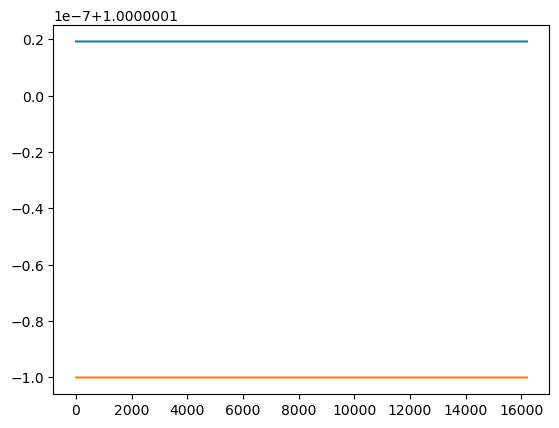

In [ ]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt


def cosine_similarity(a, b):
	return np.dot(a, b) / np.linalg.norm(a) / np.linalg.norm(b)

def req_emb_similarity(req_emb, text_embs):
	return max(cosine_similarity(req_emb, text_emb) for text_emb in text_embs)


def find_poem(request, top_n=10, lim=0., search_task=0.5):
	mentioned_parameters = extract_metadata(request)
	standard_params_text = to_standard(mentioned_parameters) + ' '
	print(mentioned_parameters)
	print(standard_params_text)
	req_params_emb = to_embeddings(standard_params_text)[0]
	if len(standard_params_text) < 14: search_task = 1
	
	req_emb = to_embeddings(request)[0]

	texts_datas = []

	for index, row in tqdm(df.iterrows()):
		text_sim = req_emb_similarity(req_emb, row['text_embedding'])
		req_sim = cosine_similarity(req_params_emb, row['metadata_embedding'])

		score = text_sim * search_task + req_sim * (1-search_task)

		texts_datas.append({'poem': row['text'], 'score': score, 'text_sim': text_sim, 'req_sim': req_sim, 
			'metadata': {k: v for k, v in row.items() if k != 'text' and k != 'metadata_embedding' and k != 'text_embedding'}})
	

	mean_req_sim = np.mean([x['req_sim'] for x in texts_datas])
	texts_datas = [x for x in texts_datas if x['req_sim'] > mean_req_sim * 1]
	
	texts_datas.sort(key=lambda x: x['score'])

	plt.plot([x['text_sim'] for x in sorted(texts_datas, key=lambda x: x['score'])], label='text')
	plt.plot([x['req_sim'] for x in sorted(texts_datas, key=lambda x: x['score'])], label='req')

	return texts_datas[-top_n:][::-1]


#request = 'из окны видны грустные пожелтевшие деревья но все же это моя любимая романтика'
#request = 'научный энтузиазм и борение за оригинальную идею'
#request = 'поднять! сделать! решительность! я! восклецания'
#request = 'дыр бул щыл убеш щур скум вы со бу р л эз'
request = 'стихотворение, поэзия, поэт, творчество, искусство'
#request = 'деревня родная природа луги поля и просторы'
#request = 'стихотворение, поэзия, поэт, творчество, искусство, Автор: Владимир Маяковский, 3 четверостишья'
#request = 'Автор: Александр Крученых'
#request = 'снова я напиваюсь'
#request = 'одиночество, когда теряет равновесие твое сознание усталое, одиночество, автор: Иосиф Бродский'

finded = find_poem(request)

for d in finded:
	print(d['poem'])
	print({k: v for k, v in d.items() if k != 'poem'})
	print('------')